In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import MySQLdb
import mysql.connector
from sqlalchemy import create_engine
import datetime as dt

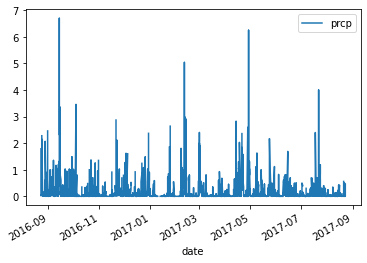

In [77]:
#clean the data to run an parcipitation analysis
measurement_data = "Resources/hawaii_measurements.csv"
stations_data = "Resources/hawaii_stations.csv"
stations = pd.read_csv(stations_data)
measurements = pd.read_csv(measurement_data)
# measurements.head(3)
# measurements.info()
measurements['date'] = pd.to_datetime(measurements['date'], format='%Y-%m-%d')
measurements.head()
reset_measurements = measurements.set_index('date')
reset_measurements.head()
rain = reset_measurements['2016-08-23' :'2017-08-23']
rain_past12mo = rain[['prcp']]
rain_past12mo.plot()
#add labels later

In [86]:
unique_station_no = len(pd.unique(stations['station'])) 
# unique_station_no = 9 
stations

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [125]:
reset_measurements
#time of observation (TOBs) changes
#To find the most active stations rank the stations by highest tobs
measurements_rankedby_tobs = reset_measurements.sort_values(by = 'tobs', ascending=False) 
measurements_rankedby_tobs
most_active_stations = measurements_rankedby_tobs[['station','tobs']]
#Total number of stations
# stations['station'] = 8 unique stations
#Stations listed by TOBs, (in descending order)
final = most_active_stations.set_index('station')
#The top 4 most active stations are: 
final.head(4)
final['tobs'].head()

station
USC00519397    87
USC00511918    87
USC00519397    87
USC00517948    87
USC00511918    86
Name: tobs, dtype: int64

In [138]:
#past 12 months of tempurature data
weather_recorded_mo12 = rain[['tobs', 'station']]
weather_4_stations_w_highest_tob = weather_recorded_mo12[(weather_recorded_mo12['station']=='USC00519397')|(weather_recorded_mo12['station']=='USC00511918')|(weather_recorded_mo12['station']=='USC00519397')|(weather_recorded_mo12['station']=='USC00517948') ]

In [141]:
#Filter by the station with the highest number of observations:
weather_4_stations_w_highest_tob.head(5)

,tobs,station
date,,
2016-08-23,81,USC00519397
2016-08-24,79,USC00519397
2016-08-25,80,USC00519397
2016-08-26,79,USC00519397
2016-08-27,77,USC00519397


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8287fa6c70>]],
      dtype=object)

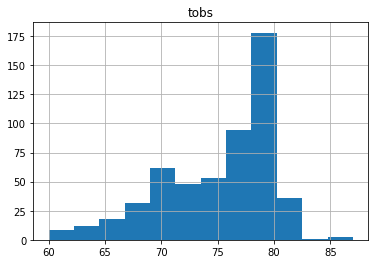

In [149]:
#Plot the results as a histogram with bins=12
# weather_4_stations_w_highest_tob.shape //(544, 2)
# weather_4_stations_w_highest_tob.dtypes //tobs: int64, station: object
#change the data types
weather_4_stations_w_highest_tob.hist(column='tobs', bins=12)


In [152]:
#Step 2 - Climate App
from flask import Flask, jsonify
from sqlalchemy.ext.automap import automap_base

#### Database setup
engine = create_engine("sqlite:///hawaii.sqlite")
# Create a new model for the database
Base = automap_base()
Base.prepare(engine, reflect=True)
# Create a new table for station data
Station = Base.classes.station
Measurements = Base.classes.measurements
# Create a session to connect the python engine to SQLite
session = Session(engine)

AttributeError: station

In [153]:
#create a flask app and the route
app = Flask(__name__)
@app.route("/api/v1.0/precipitation")
#create a definition that returns the rain data for the past 365 days 
def precipitation():
    """Return a list of rain fall for prior year"""
    last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
    last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    rain = session.query(Measurements.date, Measurements.prcp).\
        filter(Measurements.date > last_year).\
        order_by(Measurements.date).all()

In [156]:
#create a dictionary of dates as the key and rain as the value 
rain_totals = []
for result in rain:
    row = {}
    row["date"] = rain[0]
    row["prcp"] = rain[1]
    rain_totals.append(row)

return jsonify(rain_totals)

KeyError: 0

In [158]:
#create another route for station data
@app.route("/api/v1.0/stations")
def stations():
    stations_query = session.query(Station.name, Station.station)
    stations = pd.read_sql(stations_query.statement, stations_query.session.bind)
    return jsonify(stations.to_dict())

AssertionError: View function mapping is overwriting an existing endpoint function: stations

In [159]:
#create a definition that compares the number of times temps were calculated at a given station
def tobs():
    last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
    last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    temperature = session.query(Measurements.date, Measurements.tobs).\
        filter(Measurements.date > last_year).\
        order_by(Measurements.date).all()

#create a dictionary where the key is date and the value is tobs
    temperature_totals = []
    for result in temperature:
        row = {}
        row["date"] = temperature[0]
        row["tobs"] = temperature[1]
        temperature_totals.append(row)

    return jsonify(temperature_totals)

In [160]:
#create another flask route for data on my planned vacation trip dates
@app.route("/api/v1.0/<start>")
def vacation(start):   
    #format the start date to a datatiem object 
    start_date= dt.datetime.strptime(start, '%Y-%m-%d')
    #define the past 12 months as a variable
    last_year = dt.timedelta(days=365)
    #define final day of "last year"
    end =  dt.date(2017, 8, 23)
    #query for the minimum amount of rainfall recorded, the average amouunt and the max amout 
    trip_data = session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        #filer for the following three values as the fall within the beginning and end date of the vacation
        filter(Measurements.date >= start).filter(Measurements.date <= end).all()
    return jsonify(vacation)

SyntaxError: invalid syntax (<ipython-input-160-23e5920962b9>, line 12)